### All Imports

In [1]:
import gymnasium as gym                # Apply Reinforcement Learning Algorithms

from __future__ import annotations
from collections import defaultdict    # Allows Access To Keys and Donot Access

import matplotlib.pyplot as plt        # Draw Plot
from matplotlib.patches import Patch   # Draw Shapes
import numpy as np                     # Data Manipulation
import seaborn as sns

from tqdm import tqdm                  # Progess Bar

### Create Our Black Environment

In [2]:
environment = gym.make("Blackjack-v1", sab=True, render_mode="rgb_array")

### Observing Our Environment ??

In [3]:
## Reset The Environment To Get The First Observation ??

done = False
observation, info = environment.reset()

# observation = (16, 9, False)

#### Note That Our Observation Is a Tuple Of 3 Values :
- 1. The Players Current Sum
- 2. Value of The Dealers Face-up Card
- 3. Boolean whether the player holds a usable ace (An ace is usable if it counts as 11 without busting)

---

#### Executing an action

After receiving our first observation, we are only going to use the
``environment.step(action)`` function to interact with the environment. This
function takes an action as input and executes it in the environment.
Because that action changes the state of the environment, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. This variable contains a dictionary that might have some
extra information about the environment, but in the Blackjack-v1
environment you can ignore it. For example in Atari environments the
info dictionary has a ``ale.lives`` key that tells us how many lives the
agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call ``environment.render()`` in your training
loop because rendering slows down training by a lot. Rather try to build
an extra loop to evaluate and showcase the agent after training.




In [4]:
## sample a random action from all valid actions
action = environment.action_space.sample()
# action = 1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = environment.step(action=action)

# observation = (24, 10, False)
# reward = -1.0
# terminated = True
# truncated = False
# info = {}

Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the environment, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).

### Building an agent

Let’s build a ``Q-learning agent`` to solve *Blackjack-v1*! We’ll need
some functions for picking an action and updating the agents action
values. To ensure that the agents explores the environment, one possible
solution is the ``epsilon-greedy`` strategy, where we pick a random
action with the percentage ``epsilon`` and the greedy action (currently
valued as the best) ``1 - epsilon``.

In [5]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """
        Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(environment.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []
    
    def get_action (self, obs: tuple[int, int, bool]) -> int:
        ## with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return environment.action_space.sample()
        ## with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))
    
    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """
        Updates the Q-value of an action.
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )
        
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        
        self.training_error.append(temporal_difference)
    
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

Q-Value Function is used to estimate the optimal action to take in each state. It Is One That Is Maximized The Long-Term Reward.

To train the agent, we will let the agent play one episode (one complete game is called an episode) at a time and then update it’s Q-values after each episode. The agent will have to experience a lot of episodes to explore the environment sufficiently.

Now we should be ready to build the training loop.

In [6]:
## ========================
## Hyper-Parameters
## ========================

learning_rate = 0.01
n_episodes = 5000        # Set To 100000, 1000000000, ....
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

In [7]:
## Building The Agent ??

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

Great, let’s train!

Info: The current hyperparameters are set to quickly train a decent agent. If you want to converge to the optimal policy, try increasing the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).

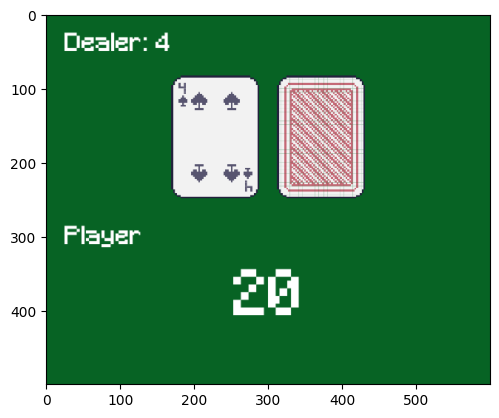

100%|██████████| 5000/5000 [28:54<00:00,  2.88it/s]


In [8]:
from IPython.display import clear_output

env = gym.wrappers.RecordEpisodeStatistics(environment)

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    clear_output()
    
    ## Play an Episode ??
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)
        
        # Diplay What Happens To Env
        frame = env.render()
        plt.imshow(frame)
        plt.show()
        
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
    
    agent.decay_epsilon()

### Let's Visualize the Training Proces ??

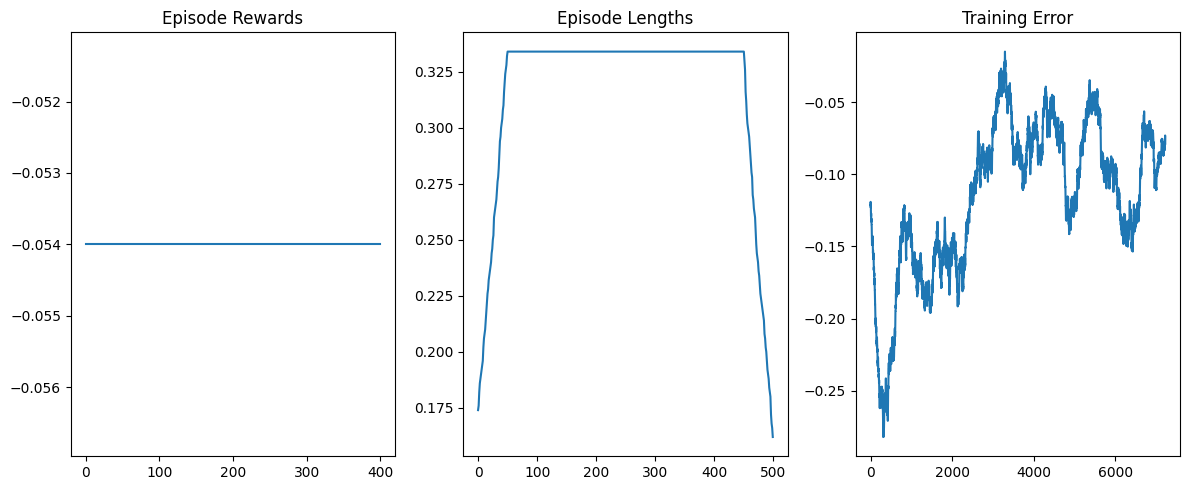

In [9]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("Episode Rewards")

# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)

axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode Lengths")

length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)

axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")

training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)

axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

The Previous Less Accuracy We See, Have Only One Reason That IS My Hyper-Parameters Only.
Because I am Running It My Own Computer and It Is With Less Capabilities.
Try To Use 
- ```learning_rate``` = 0.001 and Down More
- ```n_episodes``` = 1000000000 Increase More, Better Accuracy ??

### Visualizing The Policy ??

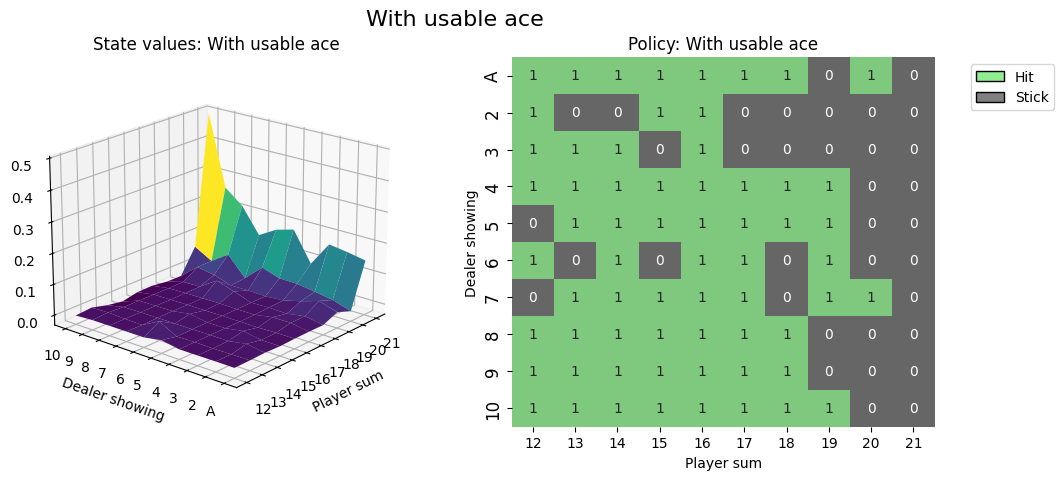

In [10]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)

fig1 = create_plots(value_grid, policy_grid, title="With usable ace")

plt.show()